<a href="https://colab.research.google.com/github/jazzveee/Music-Generator/blob/main/MusicGeneratorFinal(Type_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GENERATING MUSIC SEQUENCE IN LSTM 🎹**

We demonstrated how to generate musical notes using a simple recurrent neural network (RNN). We trained a model using a collection of piano MIDI files from the MAESTRO dataset. Given a sequence of notes, the model will learn to predict the next note in the sequence.



## Installing and Importing the Libaries 

We have used the **pretty_midi** library to create and parse MIDI files, and **pyfluidsynth** for generating audio playback.

In [ ]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 16.5 MB/s 
     |████████████████████████████████| 51 kB 7.2 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=8c75a46129bd09c75cfa18c0402889397c878e424c7b149b286fb6e7c937cc7c
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [ ]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 20 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archi

In [ ]:
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

## Downloading the Maestro Dataset

In [ ]:
import pathlib
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59252736/59243107 [==============================] - 0s 0us/step


In [ ]:
import glob
files = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(files))

Number of files: 1282


# Processing the MIDI File

We used pretty_midi to parse a single MIDI file and inspected the format of the notes.

In [ ]:
import pretty_midi
first_file = files[1]
pm = pretty_midi.PrettyMIDI(first_file)

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
SAMPLING_RATE = 16000

In [ ]:
from IPython import display
def generate_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=SAMPLING_RATE)
  waveform_short = waveform[:seconds*SAMPLING_RATE]
  return display.Audio(waveform_short, rate=SAMPLING_RATE)

Generated a PrettyMIDI object for the sample MIDI file.

In [ ]:
generate_audio(pm)

Printing the number and type of instrument used in the sample.

In [ ]:
print('Number of instruments:', len(pm.instruments))
inst = pm.instruments[0]
inst_name = pretty_midi.program_to_instrument_name(inst.program)
print('Instrument name:', inst_name)
print(inst.notes[:10])

Number of instruments: 1
Instrument name: Acoustic Grand Piano
[Note(start=0.950521, end=1.098958, pitch=79, velocity=69), Note(start=1.071615, end=1.178385, pitch=78, velocity=75), Note(start=1.175781, end=1.238281, pitch=74, velocity=78), Note(start=1.277344, end=1.460938, pitch=71, velocity=79), Note(start=1.996094, end=2.098958, pitch=62, velocity=51), Note(start=2.000000, end=2.108073, pitch=59, velocity=50), Note(start=1.445312, end=2.576823, pitch=66, velocity=92), Note(start=2.003906, end=2.596354, pitch=47, velocity=50), Note(start=2.501302, end=2.628906, pitch=55, velocity=66), Note(start=2.497396, end=2.628906, pitch=59, velocity=71)]


# Extracting the Notes

We will use three variables to represent a note when training the model: **pitch**, **step** and **duration**

In [ ]:
for i, note in enumerate(inst.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=79, note_name=G5, duration=0.1484
1: pitch=78, note_name=F#5, duration=0.1068
2: pitch=74, note_name=D5, duration=0.0625
3: pitch=71, note_name=B4, duration=0.1836
4: pitch=62, note_name=D4, duration=0.1029
5: pitch=59, note_name=B3, duration=0.1081
6: pitch=66, note_name=F#4, duration=1.1315
7: pitch=47, note_name=B2, duration=0.5924
8: pitch=55, note_name=G3, duration=0.1276
9: pitch=59, note_name=B3, duration=0.1315


In [ ]:
def midinotes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  inst= pm.instruments[0]
  notes = collections.defaultdict(list)
  sorted_notes = sorted(inst.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

**Generating notes name with get_notes_name**

The function below to convert from the numeric pitch values to note names. The note name shows the type of note, accidental and octave number (e.g. C#4).

In [ ]:
import collections
raw_notes = midinotes(first_file)
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
first_note_names = get_note_names(raw_notes['pitch'])
first_note_names[:10]

array(['G5', 'F#5', 'D5', 'B4', 'F#4', 'D4', 'B3', 'B2', 'B4', 'B3'],
      dtype='<U3')

# Creating the Training Dataset

Created the training dataset by extracting notes from the MIDI files.

In [ ]:
num_files = 5
all_notes = []
for f in files[:num_files]:
  notes = midinotes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [ ]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 32133


In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

The size of the vocabulary (vocab_size) is set to 128 representing all the pitches supported by pretty_midi.

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  seq_length = seq_length+1
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec
print(seq_ds)

<ParallelMapDataset element_spec=(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None), {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None), 'step': TensorSpec(shape=(), dtype=tf.float64, name=None), 'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})>


In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.5625     0.         0.17708333]
 [0.46875    0.01692708 0.25520833]
 [0.4609375  0.22265625 0.74479167]
 [0.5625     0.03515625 0.10416667]
 [0.4453125  0.50651042 0.75390625]
 [0.5390625  0.00520833 0.83333333]
 [0.59375    0.55208333 0.6015625 ]
 [0.5        0.00260417 0.66666667]
 [0.5625     0.88541667 0.28515625]
 [0.46875    0.00390625 0.06770833]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=57.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.0013020833333339255>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.23046875>}


In [ ]:
batch_size = 64
buffer_size = n_notes - seq_length
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

# Training the Model

The model will have three outputs, one for each note variable. For step and duration, we used a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

Testing the model.evaluate function, we observed that the **pitch loss** is significantly greater than the step and duration losses. 

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

501/501 [==============================] - 11s 4ms/step - loss: 5.1324 - duration_loss: 0.2197 - pitch_loss: 4.8500 - step_loss: 0.0627


{'loss': 5.132446765899658,
 'duration_loss': 0.21968698501586914,
 'pitch_loss': 4.85004997253418,
 'step_loss': 0.06270800530910492}

To balance this difference, we used the loss_weights argument to compile:-

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

The loss then becomes the weighted sum of the individual losses.

In [ ]:
model.evaluate(train_ds, return_dict=True)

501/501 [==============================] - 3s 4ms/step - loss: 0.5249 - duration_loss: 0.2197 - pitch_loss: 4.8500 - step_loss: 0.0627


{'loss': 0.5248972177505493,
 'duration_loss': 0.21968698501586914,
 'pitch_loss': 4.85004997253418,
 'step_loss': 0.06270800530910492}

Now, we can actually start training the model

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
501/501 [==============================] - 6s 6ms/step - loss: 0.4014 - duration_loss: 0.1424 - pitch_loss: 4.0957 - step_loss: 0.0542
Epoch 2/50
501/501 [==============================] - 3s 6ms/step - loss: 0.3877 - duration_loss: 0.1374 - pitch_loss: 3.9548 - step_loss: 0.0526
Epoch 3/50
501/501 [==============================] - 3s 6ms/step - loss: 0.3851 - duration_loss: 0.1361 - pitch_loss: 3.9404 - step_loss: 0.0520
Epoch 4/50
501/501 [==============================] - 3s 6ms/step - loss: 0.3798 - duration_loss: 0.1344 - pitch_loss: 3.8818 - step_loss: 0.0513
Epoch 5/50
501/501 [==============================] - 3s 6ms/step - loss: 0.3769 - duration_loss: 0.1332 - pitch_loss: 3.8511 - step_loss: 0.0511
Epoch 6/50
501/501 [==============================] - 3s 6ms/step - loss: 0.3731 - duration_loss: 0.1311 - pitch_loss: 3.8422 - step_loss: 0.0499
Epoch 7/50
501/501 [==============================] - 3s 6ms/step - loss: 0.3703 - duration_loss: 0.1298 - pitch_loss: 3.826

Analyzing the loss-

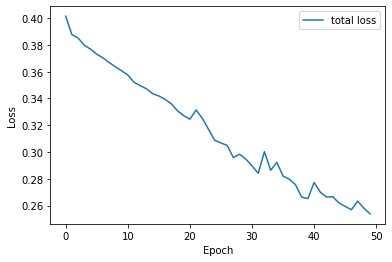

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Generating the Notes

To use the model to generate notes, we first need to provide a starting sequence of notes. 

For note pitch, it draws a sample from the softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability. Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

In [ ]:
def predict_next_note(                                          # The function generates one note from a sequence of notes.
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0                                  

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Now generate some notes. We can change the temperature and the starting sequence in next_notes to produce different outputs.

In [ ]:
temperature = 2.0                                    # The temperature parameter can be used to control the randomness of notes generated. 
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [ ]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,76,0.628722,0.194924,0.628722,0.823646
1,50,0.188927,0.253266,0.817649,1.070915
2,95,0.198908,0.315324,1.016556,1.331880
3,101,0.197683,0.331591,1.214239,1.545830
4,84,0.197317,0.376834,1.411556,1.788389
5,88,0.211266,0.436519,1.622822,2.059341
6,89,0.207549,0.484305,1.830371,2.314676
7,85,0.214313,0.495002,2.044684,2.539686
8,95,0.208256,0.482531,2.252941,2.735472
9,92,0.206951,0.502149,2.459892,2.962041


In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

# Generating the Output Sequence of Notes

In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=inst_name)
generate_audio(out_pm)

We can download the generated output from here.

In [ ]:
# from google.colab import files
# files.download(out_file)

# Visualizing the Notes

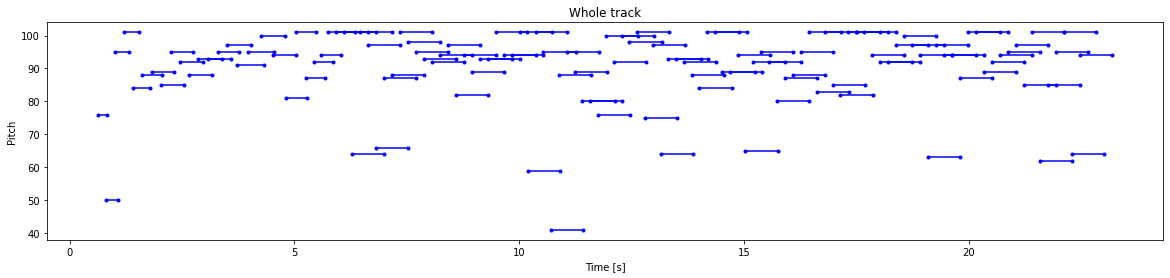

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count= None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

plot_piano_roll(generated_notes)

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch",bins=10)
  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

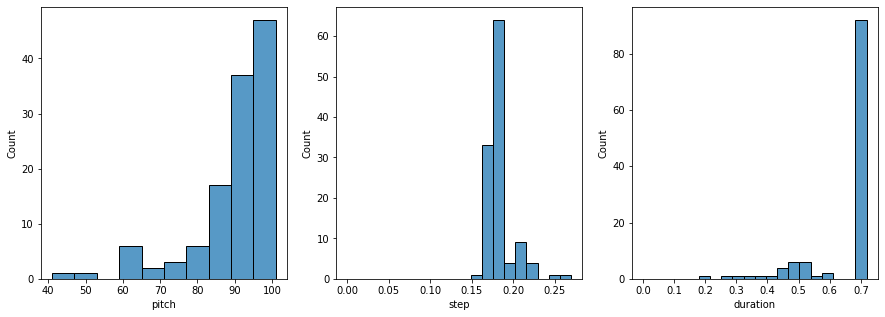

In [ ]:
plot_distributions(generated_notes)

# Analyzing the Plots

In the above plots, you will notice the change in distribution of the note variables. Since there is a feedback loop between the model's outputs and inputs, the model tends to generate similar sequences of outputs to reduce the loss. This is particularly relevant for step and duration, which uses the MSE loss. For pitch, you can increase the randomness by increasing the temperature in predict_next_note.

# Result

We successfully demonstrated the mechanics of using an RNN and generated the sequences of notes from a dataset of MIDI files.